Poems analysis
----

In this notebook we will use Minisom to cluster poems from three different authors.

Requirements:
- Glove vectors, https://nlp.stanford.edu/projects/glove/ glove.6B.50d.txt
- Beautiful soup
- An internet connection as the poems will be downlaoded from www.poemhunter.com

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Retrieving the poems from poemhunter.com
----

***Warning***: this may take a while.

In [2]:
from urllib2 import urlopen
from bs4 import BeautifulSoup

#-------------------------------------------------------------------------------

def scrape_poem(poem_url):
    poem_page = urlopen(poem_url).read()
    soup = BeautifulSoup(poem_page)
    poem = ''
    poem_string = soup.find_all("div", 
                                {"class": "KonaBody" })[0].find_all('p')[0]
    poem_string = str(poem_string)[3:-4].replace('<br/>', ' ')
    return unicode(poem_string, errors='ignore')

def scrape_poems_index(poems_index_url):
    poems_index = urlopen(poems_index_url).read()    
    soup = BeautifulSoup(poems_index)
    pages = soup.find_all("div", {"class": "pagination"})
    if len(pages) == 0:
        return get_all_links(soup)
    
    pages = pages[0].find_all('a')
    result = {}
    cnt = 0
    for page in pages:
        page_link = 'https://www.poemhunter.com/'+page['href']
        page_soup = BeautifulSoup(urlopen(page_link))
        result.update(get_all_links(page_soup))
    return result

def get_all_links(page_soup):
    result = {}
    for link in page_soup.find_all('table')[0].find_all('a'):
        result[link.text] = 'https://www.poemhunter.com/'+link['href']
    return result

def get_poems(poems_index, max_poems=None):
    poems = {}
    for i, (title, poem_url) in enumerate(poems_index.items()):
        print 'fetching', title, '...',
        try:
            poems[title] = scrape_poem(poem_url)
            print 'OK'
        except:
            print 'impossible to fetch'
        if i == max_poems-1:
            return poems
    return poems

In [3]:
poems_index_neruda = scrape_poems_index('https://www.poemhunter.com/pablo-neruda/poems/')
poems_index_bukowski = scrape_poems_index('https://www.poemhunter.com/charles-bukowski/poems/')
poems_index_poe = scrape_poems_index('https://www.poemhunter.com/edgar-allan-poe/poems/')

/Users/giuseppe.vettigli/just_experiments/venv/lib/python2.7/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html5lib"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 174 of the file /Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "html5lib")

  markup_type=markup_type))


In [4]:
poems_neruda = get_poems(poems_index_neruda, max_poems=60)
poems_bukowski = get_poems(poems_index_bukowski, max_poems=60)
poems_poe = get_poems(poems_index_poe, max_poems=60)

fetching The Night In Isla Negra ... OK
fetching Sonnet Viii ... OK
fetching Ode To A Large Tuna In The Market ... OK
fetching Magellanic Penguin ... OK
fetching La Reina  (And Translation) ... OK
fetching Come With Me, I Said, And No One Knew (VII) ... OK
fetching Ode To My Socks ... OK
fetching It’s Good To Feel You Are Close To Me ... OK
fetching Love ... OK
fetching Absence ... OK
fetching The United Fruit Co. ... OK
fetching Puedo Escribir ... OK
fetching Tie Your Heart At Night To Mine, Love, ... OK
fetching If You Forget Me ... OK
fetching Brown And Agile Child ... OK
fetching Xvii (I Do Not Love You...) ... OK
fetching Walking Around ... OK
fetching Waltz ... OK
fetching Sonnet Lxxiii: Maybe You'Ll Remember ... OK
fetching Still Another Day: I ... OK
fetching Saddest Poem ... OK
fetching The Men ... OK
fetching Finale ... OK
fetching Sonnet Lxxxi ... OK
fetching Your Laughter ... OK
fetching Sonnet Xiii:The Light That Rises From Your Feet To Your Hair ... OK
fetching Enigma Wit

In [5]:
all_poems = [poems_neruda, poems_bukowski, poems_poe]
titles = np.concatenate([title_list.keys() for title_list in all_poems])
y = np.concatenate([[i]*len(p) for i, p in enumerate(all_poems)])
all_poems = np.concatenate([p.values() for p in all_poems])

Preprocessing of the poems
---

The following operations are applied:

1. stopwords removal
2. tokenization
3. conversion in Glove vectors

In [7]:
from string import punctuation
import stop_words
stopwords = stop_words.get_stop_words('english')

def tokenize_poem(poem):
    poem = poem.lower().replace('\n', ' ')
    for sign in punctuation:
        poem = poem.replace(sign, '')
    tokens = poem.split()
    tokens = [t for t in tokens if t not in stopwords and t != '']
    return tokens

tokenized_poems = [tokenize_poem(poem) for poem in all_poems]

In [8]:
def gimme_glove():
    with open('glove.6B/glove.6B.50d.txt') as glove_raw:
        for line in glove_raw.readlines():
            splitted = line.split(' ')
            yield splitted[0], np.array(splitted[1:], dtype=np.float)
            
glove = {w: x for w, x in gimme_glove()}

def closest_word(in_vector, top_n=1):
    vectors = glove.values()
    idx = np.argsort([np.linalg.norm(vec-in_vector) for vec in vectors])
    return [glove.keys()[i] for i in idx[:top_n]]

In [9]:
def poem_to_vec(tokens):
    words = [w for w in np.unique(tokens) if w in glove]
    return np.array([glove[w] for w in words])

W = [poem_to_vec(tokenized).mean(axis=0) for tokenized in tokenized_poems]
W = np.array(W)

Running minisom and visualizing the result
----
***Warning***: This may take a while.

In [16]:
from minisom import MiniSom
map_dim = 16
som = MiniSom(map_dim, map_dim, 50, sigma=1.0, random_seed=1)
#som.random_weights_init(W)
som.train_batch(W, len(W)*500)

In [17]:
author_to_color = {0: 'chocolate',
                   1: 'steelblue',
                   2: 'dimgray'}
color = [author_to_color[yy] for yy in y]

[]

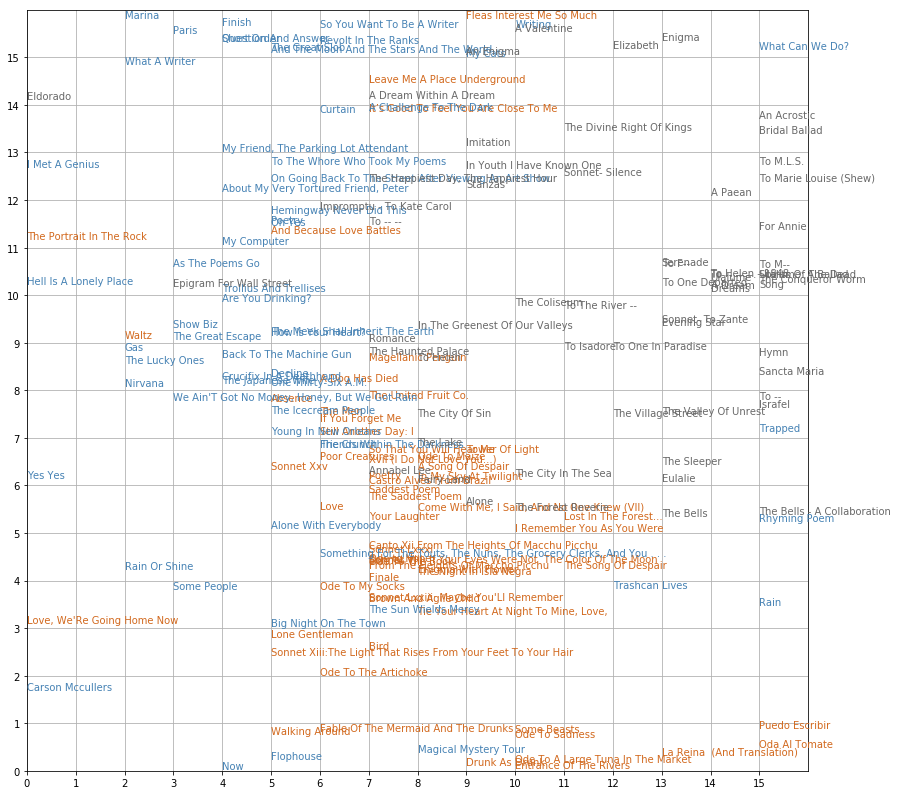

In [18]:
plt.figure(figsize=(14, 14))
for i, (t, c, vec) in enumerate(zip(titles, color, W)):
    winnin_position = som.winner(vec)
    plt.text(winnin_position[0], 
             winnin_position[1]+np.random.rand()*.9, 
             t,
             color=c)

plt.xticks(range(map_dim))
plt.yticks(range(map_dim))
plt.grid()
plt.xlim([0, map_dim])
plt.ylim([0, map_dim])
plt.plot()